In [34]:
M0    = 2
gamma = 1.4
n_div = 10
print(f'Número de pontos = {(n_div**2+5*n_div)/2:.0f}')
show_lines  = True
show_points = True
 

Número de pontos = 75


In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [36]:
def prandtl_meyer_theta(M,gamma):
    theta = np.sqrt((gamma+1)/(gamma-1))*np.atan(np.sqrt(((gamma-1)/(gamma+1)*(M**2-1))))-np.atan(np.sqrt(M**2-1))
    theta = np.degrees(theta)
    return theta

def prandtl_meyer_nu(M, gamma):
    a = np.sqrt((gamma + 1) / (gamma - 1))
    b = np.sqrt((gamma - 1) / (gamma + 1) * (M**2 - 1))
    return a * np.atan(b) - np.atan(np.sqrt(M**2 - 1))

def prandtl_meyer_M(theta, gamma, tol=1e-6, max_iter=100):
    theta = np.radians(theta)
    if theta <= 0:
        raise ValueError("θ deve ser positivo (expansão)")

    lo, hi = 1.0 + 1e-6, 50.0
    while prandtl_meyer_nu(hi, gamma) < theta:
        hi *= 2
        if hi > 1e6:
            raise ValueError("Ângulo muito grande para um M finito")

    # Bissecção
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        diff = prandtl_meyer_nu(mid, gamma) - theta
        if abs(diff) < tol:
            return mid
        if diff < 0:
            lo = mid
        else:
            hi = mid
    return mid

def angulo_mach(M):
    u = np.asin(1/M)
    u = np.degrees(u)
    return u

def K_mais(theta, nu):
    K = theta - nu
    if abs(K) < 1e-3:
        K = 0
    else:
        K = K
    return K

def K_menos(theta, nu):
    K = theta + nu
    if abs(K) < 1e-3:
        K = 0
    else:
        K = K
    return K

def nu_k_menos(theta, K):
    nu = K-theta
    return nu

def C_menos(thetai, thetai1, ui, ui1):
    thetai = np.radians(thetai)
    thetai1 = np.radians(thetai1)
    ui = np.radians(ui)
    ui1 = np.radians(ui1)

    C = np.tan((thetai+thetai1)/2-(ui+ui1)/2)
    return C

def C_mais(thetai, thetai1, ui, ui1):
    thetai = np.radians(thetai)
    thetai1 = np.radians(thetai1)
    ui = np.radians(ui)
    ui1 = np.radians(ui1)

    C = np.tan((thetai+thetai1)/2+(ui+ui1)/2)
    return C

def X_sim(Y, Y1, X, C_menos):
    X1=((Y1-Y)/C_menos)+X
    return X1

def theta_nu(K_mais,K_menos):
    theta = 0.5 * (K_mais + K_menos)
    nu    = 0.5 * (K_menos - K_mais)
    return theta, nu

def XY_n_sim(X0,Y0,X1,Y1,C_menos,C_mais):
    X2 = (C_mais*X1 - C_menos*X0 + (Y0 - Y1)) / (C_mais - C_menos)
    Y2 = C_mais*(X2 - X1) + Y1
    return X2, Y2

def angulo_mach_inv(u):
    u = np.radians(u)
    M = 1/np.sin(u)
    return M

In [37]:
def Ponto_0(nome_ponto, theta):
    X, Y = 0.0, 1.0
    M    = prandtl_meyer_M(theta, gamma)
    nu   = prandtl_meyer_theta(M,   gamma)
    mu   = angulo_mach(M)
    Kp   = K_mais(theta, nu)
    Km   = K_menos(theta, nu)
    
    '''
    print(f'---------------------- Ponto {nome_ponto} ----------------------')
    print(f"Valor de X        = {X:.3f}")
    print(f"Valor de Y        = {Y:.3f}")
    print(f"Valor de θ        = {theta:.3f}")
    print(f"Valor de ν        = {nu:.3f}")
    print(f"Valor de M        = {M:.3f}")
    print(f"Valor de μ        = {mu:.3f}")
    print(f"Valor de C⁺       = -")
    print(f"Valor de C⁻       = -")
    print(f"Valor de K⁺       = {Kp:.3f}")
    print(f"Valor de K⁻       = {Km:.3f}\n")
    '''
    
    tupla = (nome_ponto, X, Y, theta, nu, M, mu, None, None, Kp, Km)
    return X, Y, theta, nu, M, mu, None, None, Kp, Km, tupla

In [38]:
def Ponto_1(nome_ponto, ponto0, gamma):
    X0     = ponto0["x"]
    Y0     = ponto0["y"]
    theta0 = ponto0["theta"]
    mu0    = ponto0["mu"]
    Km0    = ponto0["Kmenos"] 


    theta = 0.0
    Y     = 0.0
    nu    = Km0
    M     = prandtl_meyer_M(nu, gamma)
    mu    = angulo_mach(M)
    Cm = C_menos(theta0, theta, mu0, mu)
    X = X_sim(Y0, Y, X0, Cm)
    Kp = K_mais(theta, nu)
    Km = K_menos(theta, nu)

    '''
    print(f'---------------------- Ponto {nome_ponto} ----------------------')
    print(f"Valor de X          = {X:.3f}")
    print(f"Valor de Y          = {Y:.3f}")
    print(f"Valor de θ          = {theta:.3f}")
    print(f"Valor de ν          = {nu:.3f}")
    print(f"Valor de M          = {M:.3f}")
    print(f"Valor de μ          = {u:.3f}")
    print(f"Valor de C_mais     = -")
    print(f"Valor de C_menos    = {Cm:.3f}")
    print(f"Valor de K_mais     = {Kp:.3f}")
    print(f"Valor de K_menos    = {Km:.3f}")
    '''

    tupla = (nome_ponto, X, Y, theta, nu, M, mu, None, Cm, Kp, Km)
    return X, Y, theta, nu, M, mu, None, Cm, Kp, Km, tupla

In [39]:
def Ponto_mid(nome_ponto, ponto01, ponto02, gamma):   
    X01 = ponto01["x"]
    Y01 = ponto01["y"]
    theta01 = ponto01["theta"]
    mu01 = ponto01["mu"]
    Km01 = ponto01["Kmenos"]
    
    X02 = ponto02["x"]
    Y02 = ponto02["y"]
    theta02 = ponto02["theta"]
    mu02 = ponto02["mu"]
    Kp02 = ponto02["Kmais"]

    
    Kp = Kp02
    Km = Km01
    theta, nu = theta_nu(Kp,Km)
    M = prandtl_meyer_M(nu, gamma)
    mu = angulo_mach(M)
    Cm = C_menos(theta01, theta, mu01, mu)
    Cp = C_mais(theta02, theta, mu02, mu)
    X, Y = XY_n_sim(X01,Y01,X02,Y02,Cm,Cp)

    '''
    print(f'---------------------- Ponto {nome_ponto} ----------------------')
    print(f"Valor de X          = {X:.3f}")
    print(f"Valor de Y          = {Y:.3f}")
    print(f"Valor de θ          = {theta:.3f}")
    print(f"Valor de ν          = {nu:.3f}")
    print(f"Valor de M          = {M:.3f}")
    print(f"Valor de μ          = {u:.3f}")
    print(f"Valor de C_mais     = -")
    print(f"Valor de C_menos    = {Cm:.3f}")
    print(f"Valor de K_mais     = {Kp:.3f}")
    print(f"Valor de K_menos    = {Km:.3f}")
    '''

    tupla = (nome_ponto, X, Y, theta, nu, M, mu, Cp, Cm, Kp, Km)
    return X, Y, theta, nu, M, mu, Cp, Cm, Kp, Km, tupla

In [40]:
def Ponto_parede(nome_ponto, ponto01, ponto02, gamma):
    X01 = ponto01["x"]
    Y01 = ponto01["y"]
    theta01 = ponto01["theta"]
    
    X02 = ponto02["x"]
    Y02 = ponto02["y"]
    theta02 = ponto02["theta"]
    mu02 = ponto02["mu"]
    
    theta = theta02
    mu = mu02
    
    Cp = C_mais(theta02, theta, mu02, mu)
    Cm = C_menos(theta01, theta, 0, 0)
    X, Y = XY_n_sim(X01,Y01,X02,Y02,Cm,Cp)
    M = angulo_mach_inv(mu)
    nu = prandtl_meyer_theta(M,gamma)
    Kp = K_mais(theta, nu)
    Km = K_menos(theta, nu)

    '''
    print(f'---------------------- Ponto {nome_ponto} ----------------------')
    print(f"Valor de X          = {X:.3f}")
    print(f"Valor de Y          = {Y:.3f}")
    print(f"Valor de θ          = {theta:.3f}")
    print(f"Valor de ν          = {nu:.3f}")
    print(f"Valor de M          = {M:.3f}")
    print(f"Valor de μ          = {mu:.3f}")
    print(f"Valor de C_mais     = {Cp:.3f}")
    print(f"Valor de C_menos    = {Cm:.3f}")
    print(f"Valor de K_mais     = {Kp:.3f}")
    print(f"Valor de K_menos    = {Km:.3f}")
    '''

    tupla = (nome_ponto, X, Y, theta, nu, M, mu, Cp, Cm, Kp, Km)
    return X, Y, theta, nu, M, mu, Cp, Cm, Kp, Km, tupla

In [41]:
linhas = []
pontos = {}

theta_max = prandtl_meyer_theta(M0, gamma) / 2
step       = theta_max / n_div
theta_space = np.arange(step, theta_max + 1e-12, step)

In [42]:
for idx, theta_i in enumerate(theta_space, start=1):
    nome = f"0,{idx}"
    X, Y, th, nu, M, mu , *_ , Kp, Km, tupla = Ponto_0(nome, theta_i)
    
    pontos[nome] = {
        "x": X, "y": Y, "theta": th, "nu": nu, "M": M, "mu": mu,
        "Cmais": None, "Cmenos": None, "Kmais": Kp, "Kmenos": Km
    }
    
    linhas.append(tupla)

In [43]:
nome_ctr = f"1"
X, Y, th, nu, M, mu, *_ , Cm , Kp, Km, tupla = Ponto_1(nome_ctr,pontos["0,1"], gamma)

pontos["1"] = {
    "x": X, "y": Y, "theta": th, "nu": nu, "M": M, "mu": mu,
    "Cmais": None, "Cmenos": Cm, "Kmais": Kp, "Kmenos": Km
    } 

linhas.append(tupla)

In [44]:
idx_seq      = 2 
prev_centro  = "1" 
prev_parede  = "0,1" 
wall_idx     = 1 

mids_anteriores = []
for k in range(2, n_div + 1):

    # ---------- ponto MEIO da faixa k ----------
    nome_mid  = f"{idx_seq}"
    p_wall    = pontos[f"0,{k}"]
    p_cmais   = pontos[prev_centro]

    Xm, Ym, thm, num, Mm, mum, Cp_m, Cm_m, Kp_m, Km_m, tupla_mid = \
        Ponto_mid(nome_mid, p_wall, p_cmais, gamma)

    pontos[nome_mid] = {
        "x": Xm, "y": Ym, "theta": thm, "nu": num, "M": Mm, "mu": mum,
        "Cmais": Cp_m, "Cmenos": Cm_m, "Kmais": Kp_m, "Kmenos": Km_m,
    }
    linhas.append(tupla_mid)
    idx_seq += 1

    # ---------- pontos interno-interno (ii) ----------
    for nome_prev in mids_anteriores:
        nome_ii = f"{idx_seq}"

        Xi, Yi, thi, nui, Mi, mui, Cp_i, Cm_i, Kp_i, Km_i, tup_ii = \
            Ponto_mid(nome_ii, pontos[nome_mid], pontos[nome_prev], gamma)

        pontos[nome_ii] = {
            "x": Xi, "y": Yi, "theta": thi, "nu": nui, "M": Mi, "mu": mui,
            "Cmais": Cp_i, "Cmenos": Cm_i, "Kmais": Kp_i, "Kmenos": Km_i,
        }
        linhas.append(tup_ii)
        idx_seq += 1

    mids_anteriores.append(nome_mid)

    # ---------- PAREDE ----------
    nome_w = f"w{wall_idx}"
    Xp, Yp, thp, nup, Mp, mup, Cp_p, Cm_p, Kp_p, Km_p, tupla_p = Ponto_parede(nome_w, p_wall, pontos[nome_mid], gamma)

    pontos[nome_w] = {
        "x": Xp, "y": Yp, "theta": thp, "nu": nup, "M": Mp, "mu": mup,
        "Cmais": Cp_p, "Cmenos": Cm_p, "Kmais": Kp_p, "Kmenos": Km_p,
    }
    linhas.append(tupla_p)
    prev_parede = nome_w
    wall_idx   += 1

    # ---------- ponto no “CHÃO” (centro da nova faixa) ----------
    nome_ctr = f"{idx_seq}"
    Xc, Yc, thc, nuc, Mc, muc, Cp_c, Cm_c, Kp_c, Km_c, tupla_ctr = \
        Ponto_1(nome_ctr, pontos[nome_mid], gamma)

    pontos[nome_ctr] = {
        "x": Xc, "y": Yc, "theta": thc, "nu": nuc, "M": Mc, "mu": muc,
        "Cmais": Cp_c, "Cmenos": Cm_c, "Kmais": Kp_c, "Kmenos": Km_c,
    }
    linhas.append(tupla_ctr)
    prev_centro = nome_ctr
    idx_seq += 1


In [45]:
nome_w = f"w{wall_idx}"
Xp, Yp, thp, nup, Mp, mup, Cp_p, Cm_p, Kp_p, Km_p, tupla_p = Ponto_parede(nome_w, pontos[prev_parede], pontos[prev_centro], gamma)

pontos[nome_w] = {
    "x": Xp, "y": Yp, "theta": thp, "nu": nup, "M": Mp, "mu": mup,
    "Cmais": Cp_p, "Cmenos": Cm_p, "Kmais": Kp_p, "Kmenos": Km_p,
}
linhas.append(tupla_p)

In [46]:
colunas = ["Ponto", "x", "y", "θ (deg)", "ν (deg)", "M", "μ (deg)",
           "C⁺ dy/dx", "C⁻ dy/dx", "K⁺", "K⁻"]

df = pd.DataFrame(linhas, columns=colunas)

df = df.replace({None: np.nan})
num_cols = df.columns.drop("Ponto")
df[num_cols] = df[num_cols].astype(float)

fmt = {c: "{:.3f}" for c in num_cols}
tabela = df.style.format(fmt, na_rep="-")

display(tabela)

,Ponto,x,y,θ (deg),ν (deg),M,μ (deg),C⁺ dy/dx,C⁻ dy/dx,K⁺,K⁻
0,"0,1",0.000,1.000,1.319,1.319,1.099,65.482,-,-,0.000,2.638
1,"0,2",0.000,1.000,2.638,2.638,1.161,59.438,-,-,0.000,5.276
2,"0,3",0.000,1.000,3.957,3.957,1.216,55.321,-,-,0.000,7.914
3,"0,4",0.000,1.000,5.276,5.276,1.267,52.123,-,-,0.000,10.552
4,"0,5",0.000,1.000,6.595,6.595,1.315,49.482,-,-,0.000,13.190
5,"0,6",0.000,1.000,7.914,7.914,1.362,47.219,-,-,0.000,15.828
6,"0,7",0.000,1.000,9.233,9.233,1.409,45.232,-,-,0.000,18.466
7,"0,8",0.000,1.000,10.552,10.552,1.454,43.457,-,-,0.000,21.104
8,"0,9",0.000,1.000,11.871,11.871,1.499,41.850,-,-,0.000,23.742
9,"0,10",0.000,1.000,13.190,13.190,1.544,40.381,-,-,0.000,26.380


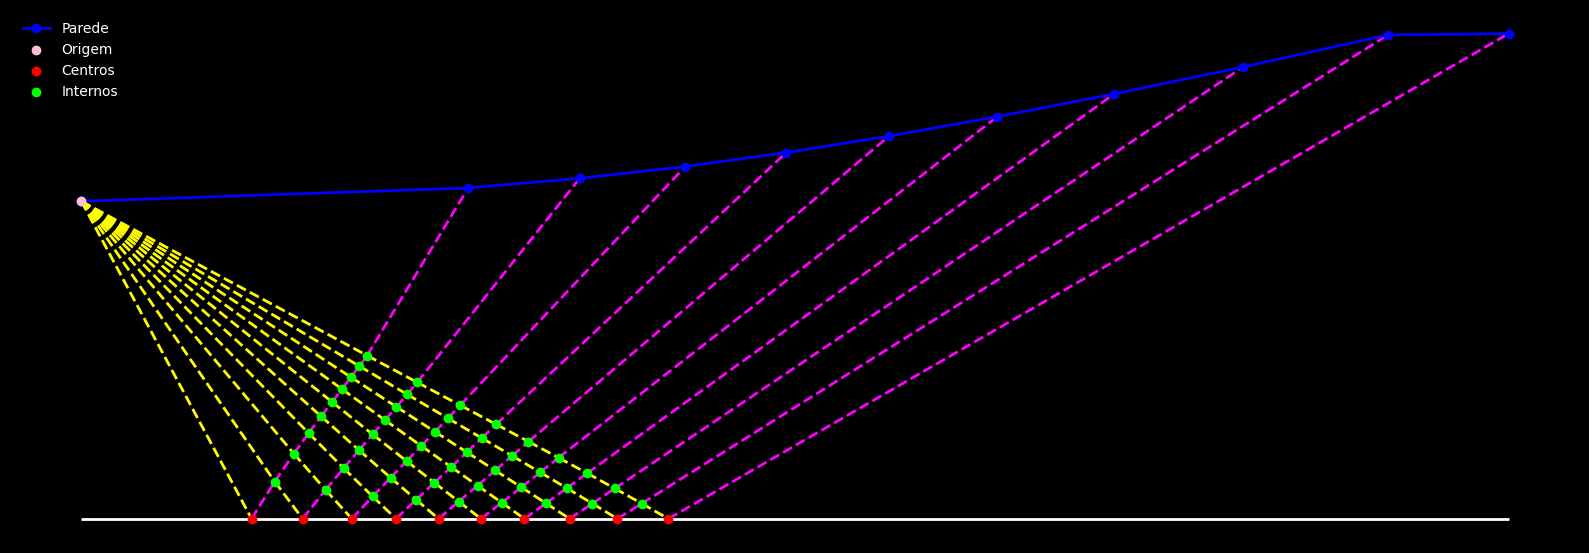

In [47]:
wall_mask     = df["Ponto"].str.startswith(("0,", "w"))
center_mask   = (df["y"] == 0.0) & (~wall_mask)
internal_mask = ~(wall_mask | center_mask)

wall_pts     = df[wall_mask].sort_values("x")
center_pts   = df[center_mask].sort_values("x")
internal_pts = df[internal_mask]

p = {str(r.Ponto): (r.x, r.y) for r in df.itertuples()}
x0, y0 = p["0,1"]

fig, ax = plt.subplots(figsize=(16, 10))
fig.patch.set_facecolor("black")
ax.set_facecolor("black")

# --- Parede ---
wall_marker = "o" if show_points else None
ax.plot(wall_pts["x"], wall_pts["y"],
        color="blue", lw=2, marker=wall_marker, label="Parede", zorder=3)

# --- Linha de simetria (y = 0) ---
ax.hlines(0, wall_pts["x"].min(), wall_pts["x"].max(),
          color="white", ls="-", lw=2, zorder=1)

# --- Pontos (somente se show_points) ---
if show_points:
    ax.scatter(0, 1, c="pink", marker="o", label="Origem", zorder=4)
    ax.scatter(center_pts["x"],  center_pts["y"],
               c="red",  marker="o", label="Centros",  zorder=4)
    ax.scatter(internal_pts["x"], internal_pts["y"],
               c="lime", marker="o", label="Internos", zorder=4)

if show_lines:
    centers = list(center_pts["Ponto"].astype(str))
    n_lines = len(centers)

    # ----origem (0,1) ----
    def slope(lbl):
        x, y = p[lbl]; return (y - y0) / (x - x0)

    # crescente
    centers.sort(key=lambda lbl: slope(lbl))
    bounds = [-np.inf] + list((np.diff([slope(c) for c in centers]) / 2
                               + np.array([slope(c) for c in centers][:-1])).tolist()) + [+np.inf]

    # ---- linhas amarelas ----
    lines = [[] for _ in range(n_lines)]
    for lbl in list(internal_pts["Ponto"].astype(str)) + centers:
        if lbl == "0,1": continue
        idx = np.searchsorted(bounds, slope(lbl), side="right") - 1
        lines[idx].append(lbl)

    for lst in lines:
        lst.sort(key=lambda lbl: p[lbl][0])

    # ---- AMARELOS: origem → sequência de cada faixa ---
    for lst in lines:
        # origem → primeiro
        ax.plot([x0, p[lst[0]][0]], [y0, p[lst[0]][1]],
                color="yellow", ls="--", lw=2, zorder=3)
        # entre nós
        for a, b in zip(lst[:-1], lst[1:]):
            ax.plot([p[a][0], p[b][0]], [p[a][1], p[b][1]],
                    color="yellow", ls="--", lw=2, zorder=3)


    max_len = max(len(lst) for lst in lines)
    for k in range(max_len):
        layer = [lst[k] for lst in lines if len(lst) > k]
        # conecta da esquerda p/ direita
        for a, b in zip(layer[:-1], layer[1:]):
            ax.plot([p[a][0], p[b][0]], [p[a][1], p[b][1]],
                    color="magenta", ls="--", lw=2, zorder=2)
        # fecho → parede correspondente
        w_lbl = f"w{k+1}"
        if w_lbl in p:
            last = layer[-1]
            ax.plot([p[last][0], p[w_lbl][0]],
                    [p[last][1], p[w_lbl][1]],
                    color="magenta", ls="--", lw=2, zorder=2)

ax.set_aspect("equal", "box")
ax.set_xticks([]); ax.set_yticks([])
ax.grid(False)

handles, labels = ax.get_legend_handles_labels()
if handles:
    ax.legend(handles, labels,
              facecolor="black", framealpha=1,
              loc="upper left", edgecolor="black", labelcolor="white")

plt.tight_layout()
plt.show()


In [48]:
folder = r"C:\Users\Joao\Desktop\Python\resultado"
os.makedirs(folder, exist_ok=True)

csv_path = os.path.join(folder, "tabela.csv")
df.to_csv(csv_path, index=False)
print(f"Tabela salva em: {csv_path}")

img_path = os.path.join(folder, "bocal.png")
fig.savefig(img_path, dpi=300, bbox_inches="tight")
plt.close(fig)

print(f"Imagem salva em: {img_path}")

Tabela salva em: C:\Users\Joao\Desktop\Python\resultado/tabela.csv
Imagem salva em: C:\Users\Joao\Desktop\Python\resultado/bocal.png
